# Statistic testing

**Imports**

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# system import to access file on different directory 
import sys
sys.path.append("/Users/migashane/CodeUp/Data_Science/telco_churn_classification_project/util_")
import prepare_
import explore_

# set a default them for all my visuals
sns.set_theme(style="whitegrid")


**Get and split data**

In [2]:
# load data
telco = prepare_.clean_telco_without_dummies()

# split data into train, validate and test
train, validate, test = prepare_.split_data_(df=telco,
                     test_size=0.2, 
                     validate_size=0.2,
                    stratify_col="churn",
                    random_state=95)

# look at the different splits
train.shape, validate.shape, test.shape

((4225, 20), (1409, 20), (1409, 20))

**Questions**

- Are customers with DSL more or less likely to churn?
- What month are customers most likely to churn and does that depend on their contract type?
- Is there a service that is associated with more churn than expected?
- Do customers who churn have a higher average monthly spend than those who don't?

## 1. Are customers with DSL more or less likely to churn?

For this stat test I will compare the assiciation of DSL customers with churcn using the chi-squared test, because I am comparing two discrate features.

- $H_0$: There is no association between DSL customers and churn.
- $H_a$: There is an association between DSL customers and churn.

I am first just gonna run a quick contegency table to see how churn connects with internet types.

In [3]:
print("Null_hyp: There is no association between DSL customers and churn.")
print("Alt_hyp: There is an association between DSL customers and churn.")

# run a contegency tale
cont_table = pd.crosstab(train.churn, train.internet_service_type)
cont_table

Null_hyp: There is no association between DSL customers and churn.
Alt_hyp: There is an association between DSL customers and churn.


internet_service_type,DSL,Fiber optic,None
churn,,,
No,1195,1075,834
Yes,271,774,76


Now I will set my confidence level and run the chi-squared test.

In [4]:
# set significance level
alpha = 0.05

# test stats
chi2, p_value, degreeFreedom, exp_table = stats.chi2_contingency(cont_table)

# print results
print("chi2:", chi2)
print("p-value:", p_value)
print("defrees of freedom:", degreeFreedom, "\n\n")

print(cont_table)
pd.DataFrame(exp_table)

chi2: 425.868387757013
p-value: 3.3408316397762297e-93
defrees of freedom: 2 


internet_service_type   DSL  Fiber optic  None
churn                                         
No                     1195         1075   834
Yes                     271          774    76


,0,1,2
0,1077.032899,1358.413254,668.553846
1,388.967101,490.586746,241.446154


In [5]:
# oompare p-value to alpha
if p_value < alpha:
    print("We have enough evidence to reject the null")
else:
    print("we fail to reject the null at this time")

We have enough evidence to reject the null


**conclusion**

- The test rejects the null showing that ther is some association (dependence) between DSL customers and churn.

- The contingency tables show that DSL customers are doing a lot better than expected. Telco is keeping over 100 of the DSL customers, but we are losing about 280 customers more than expected on fiber optic.

## 2. What month are customers most likely to churn and does that depend on their contract type?

Here I will test the correlation between monthly charges, and tenure and separete them by churn. I will then try to control to their contract type to identify impact of contract on churn in regards to monthly charges.

### 2.1 First, is there a linear relationship between monthly charges and tenure.

- $H_0$: There is not linear relationship between monthly charges and tenure.
- $H_a$: There is linear relationship between monthly charges and tenure.

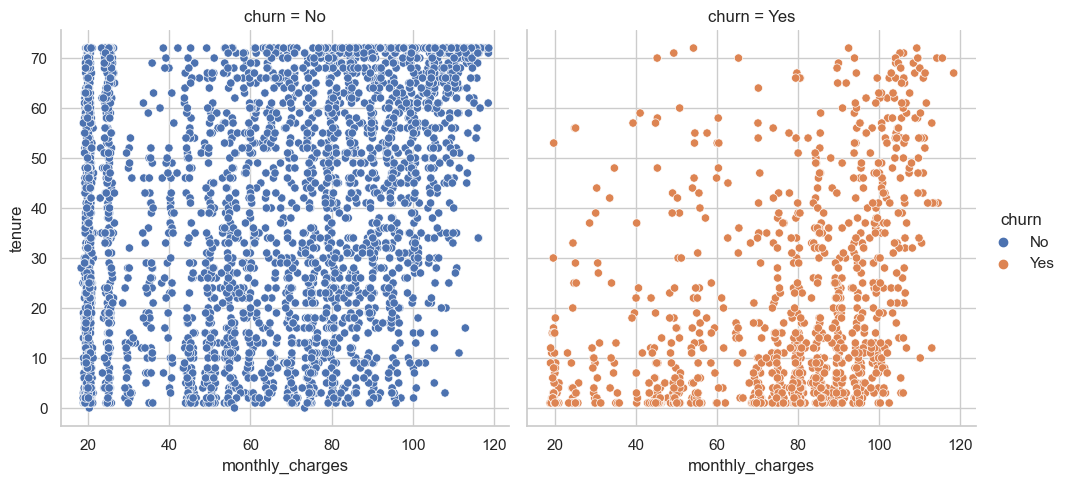

In [6]:
# plot the columns
sns.relplot(data=train, x="monthly_charges", y="tenure", hue="churn",col="churn")

|I see a linear relationship on the churn visual on the right. In that case I will attempt to run a pearson'r correlation test.

In [7]:
# confidence level
alpha = 0.05

# perform the pearson's rcorrelation test
r, p_value = stats.pearsonr(train.monthly_charges, train.tenure)

# print results
print("coeficient r:", r)
print("p-value:", p_value)
explore_._verify_alpha_(p_value) # compare p-value to alpha

coeficient r: 0.25345512137071063
p-value: 6.280619214616743e-63
We have enough evidence to reject the null


**Conclusion**

- The test rejects the null showing that ther is a linear relationship (dependence) between monthly charges and tenure.

- The visual shows that high numer of people churn with in the first 30 month with Telco.

### 2.2 Are customers more or less likely to churn within the first 24 month with Telco

First I will determin the churn rate. I will do this using the one sample t-test to answer my question.

- $H_0$: Customer churn rate with in the first 24 month is > 50%
- $H_a$: Customer churn rate with in the first 24 month is <= 50%


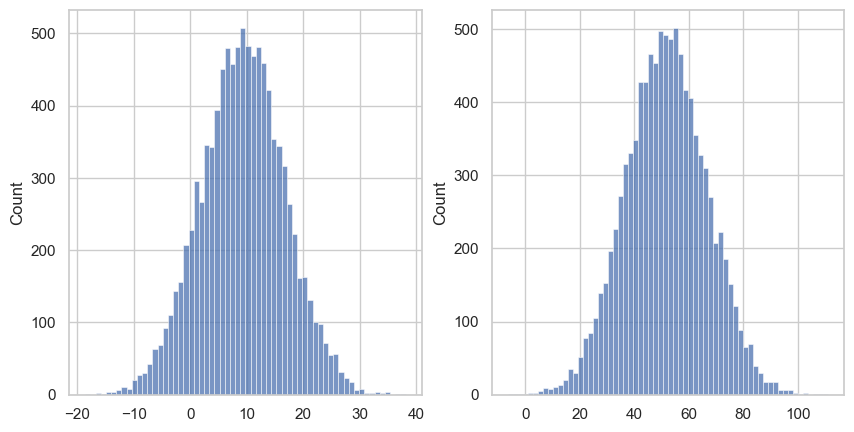

In [8]:
# separate firt 24 month from all other
first_24 = train[train.tenure <= 24]
other = train[train.tenure > 24]

# create mean and stanrd deviation for the two groups
first_24_mean, first_24_std = first_24.tenure.mean(), first_24.tenure.std()
other_mean, other_std = other.tenure.mean(), other.tenure.std()

# create distribution objects
first_24_dist = stats.norm(first_24_mean, first_24_std)
other_dist = stats.norm(other_mean, other_std)

# generate random variables
first_24_rand = first_24_dist.rvs(10_000)
other_rand = other_dist.rvs(10_000)

#plot
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
sns.histplot(first_24_rand, ax=ax[0])
sns.histplot(other_rand, ax=ax[1])
plt.show()


In [9]:
# confidence level
alpha = 0.05

# test statistics
t_stats, p_value = stats.ttest_1samp(first_24_mean, other_mean)

# print results
print("test stats:", t_stats)
print("p-Value:",  p_value)

# oompare p-value to alpha
if (t_stats > 0) and (p_value//2 < alpha):
    print("We have enough evidence to reject the null")
else:
    print("we fail to reject the null at this time")

test stats: nan
p-Value: nan
we fail to reject the null at this time


/opt/homebrew/anaconda3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/homebrew/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Test fails to reject the null. Customer churn rate with in the first 24 months looks to be more than 50%

### 2.3 To answer the main question

I will look with in the first 24 months and compare it with the contract type. I will uses the chi-squred test here to ansser my question

- $H_0$: The churn month is independent (no association) of the contract type.
- $H_a$: The churn month is dependent (association) of the contract type.

In [10]:
# retrieve my two groups
first_24 = train[train.tenure <= 24].tenure
contract_type = train[train.tenure <= 24].contract_type

cont_table = pd.crosstab(contract_type, first_24)
cont_table

tenure,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
contract_type,,,,,,,,,,,,,,,,,,,,,
Month-to-month,0,345,136,119,97,72,60,70,59,65,...,43,37,29,49,30,30,24,37,30,43
One year,0,3,5,5,4,4,5,6,5,4,...,9,5,17,10,9,8,5,11,19,12
Two year,3,2,1,1,3,0,7,3,8,2,...,4,3,4,4,6,1,3,4,7,12


In [11]:
# set significance level
alpha = 0.05

# test stats
chi2, p_value, degreeFreedom, exp_table = stats.chi2_contingency(cont_table)

# print results
print("chi2:", chi2)
print("p-value:", p_value)
print("defrees of freedom:", degreeFreedom, "\n\n")

print("Expected")
pd.DataFrame(exp_table)

chi2: 310.9598463433192
p-value: 3.47462124046064e-40
defrees of freedom: 48 


Expected


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,2.550079,297.509177,120.703723,106.253277,88.402727,64.601993,61.201888,67.152071,61.201888,60.351862,...,47.601468,38.251180,42.501311,53.551652,38.251180,33.151023,27.200839,44.201363,47.601468,56.951757
1,0.297326,34.687992,14.073414,12.388568,10.307289,7.532250,7.135815,7.829575,7.135815,7.036707,...,5.550079,4.459885,4.955427,6.243838,4.459885,3.865233,3.171474,5.153644,5.550079,6.640273
2,0.152596,17.802832,7.222863,6.358154,5.289984,3.865758,3.662297,4.018353,3.662297,3.611432,...,2.848453,2.288936,2.543262,3.204510,2.288936,1.983744,1.627687,2.644992,2.848453,3.407971


In [12]:
# conclusion
explore_._verify_alpha_(p_value)

We have enough evidence to reject the null


**Conclusion**

- Tests show that we have enough evidence to say that customers are more likly to churn withn the first 24 month and indeed it depends on contract type.

## 3. Does the customer having a partner or dependents affect churn.

**Customer having partber**
- $H_0$: A customer having a parner does not affect churn.
- $H_a$: A customer having aparter does affect churn.

In [13]:
print("Null_hyp: A customer having a parner does not affect churn.")
print("Alt_hyp: A customer having aparter does affect churn.")

# run a contegency tale
cont_table = pd.crosstab(train.churn, train.partner)
cont_table

Null_hyp: A customer having a parner does not affect churn.
Alt_hyp: A customer having aparter does affect churn.


partner,No,Yes
churn,,
No,1435,1669
Yes,707,414


In [14]:
# set significance level
alpha = 0.05

# test stats
chi2, p_value, degreeFreedom, exp_table = stats.chi2_contingency(cont_table)

# print results
print("chi2:", chi2)
print("p-value:", p_value)
print("defrees of freedom:", degreeFreedom, "\n\n")

print(cont_table)
pd.DataFrame(exp_table)

chi2: 92.74485359818155
p-value: 5.948991967109298e-22
defrees of freedom: 1 


partner    No   Yes
churn              
No       1435  1669
Yes       707   414


,0,1
0,1573.672899,1530.327101
1,568.327101,552.672899


In [15]:
explore_._verify_alpha_(p_value)

We have enough evidence to reject the null


**Customer having dependents**
- $H_0$: A customer having dependents does not affect churn.
- $H_a$: A customer having dependents does affect churn.

In [16]:
print("Null_hyp: A customer having dependents does not affect churn.")
print("Alt_hyp: A customer having dependents does affect churn.")

# run a contegency tale
cont_table = pd.crosstab(train.churn, train.dependents)
cont_table

Null_hyp: A customer having dependents does not affect churn.
Alt_hyp: A customer having dependents does affect churn.


dependents,No,Yes
churn,,
No,2009,1095
Yes,917,204


In [17]:
# set significance level
alpha = 0.05

# test stats
chi2, p_value, degreeFreedom, exp_table = stats.chi2_contingency(cont_table)

# print results
print("chi2:", chi2)
print("p-value:", p_value)
print("defrees of freedom:", degreeFreedom, "\n\n")

print(cont_table)
pd.DataFrame(exp_table)

chi2: 112.02206779953576
p-value: 3.533551213715458e-26
defrees of freedom: 1 


dependents    No   Yes
churn                 
No          2009  1095
Yes          917   204


,0,1
0,2149.657751,954.342249
1,776.342249,344.657751


In [18]:
explore_._verify_alpha_(p_value)

We have enough evidence to reject the null


## 4. Do customers who churn have a higher average monthly spend than those who don't?

- $H_0$: Customers who churn have a higher monthly average than those who don't.
- $H_a$: Customers who churn have a lower monthly average than those who don't.

Null_hyp: Customers who churn have a higher monthly average than those who don't.
Alt_hyp: Customers who churn have a lower monthly average than those who don't.

CHURN VS NO-CHRUN TOTAL CHARGES DISTRIBUTIONS


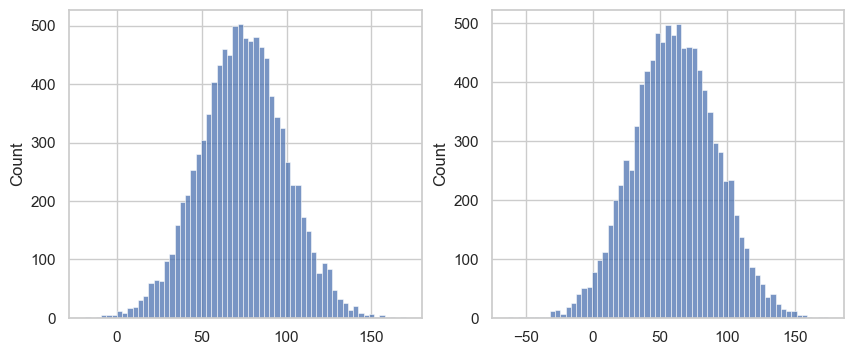

In [19]:
print("Null_hyp: Customers who churn have a higher monthly average than those who don't.")
print("Alt_hyp: Customers who churn have a lower monthly average than those who don't.")

# separate churn customers from those who don't
churn_cus = train[train.churn == "Yes"].monthly_charges
no_churn_cus = train[train.churn == "No"].monthly_charges

# get mean and standard deviation
churn_cus_mean, churn_cus_std = churn_cus.mean(), churn_cus.std()
no_churn_cus_mean, no_churn_cus_std = no_churn_cus.mean(), no_churn_cus.std()

# get distribution and random variables
churn_cus_dist = stats.norm(churn_cus_mean, churn_cus_std).rvs(10_000)
no_churn_cus_dist = stats.norm(no_churn_cus_mean, no_churn_cus_std).rvs(10_000)

# Plot distribution
print("\nChurn vs No-chrun total charges distributions".upper())
fig, ax = plt.subplots(1,2, figsize=(10,4))

sns.histplot(churn_cus_dist, ax=ax[0])
sns.histplot(no_churn_cus_dist, ax=ax[1])
plt.show()

In [20]:
# confidence level
alpha = 0.05

# test statistics
t_stats, p_value = stats.ttest_1samp(churn_cus_mean, no_churn_cus_mean)

# print results
print("test stats:", t_stats)
print("p-Value:",  p_value)

# oompare p-value to alpha
if (t_stats > 0) and (p_value//2 < alpha):
    print("We have enough evidence to reject the null")
else:
    print("we fail to reject the null at this time")

test stats: nan
p-Value: nan
we fail to reject the null at this time


/opt/homebrew/anaconda3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/homebrew/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
